In [1]:
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
MAIN_PATH = os.path.dirname(os.getcwd())
DATA_PATH = MAIN_PATH + "/data/unprocessed/WESAD"


In [3]:
def load_data_in_chunks(file_path, subject_id, chunksize=100000):
    """Load data in chunks, assign ID and return concatenated DataFrame."""
    chunks = []
    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        chunk['ID'] = subject_id  # Assign subject ID to each chunk
        chunks.append(chunk)  # Collect the chunk
    return pd.concat(chunks, ignore_index=True)  # Concatenate all chunks


In [4]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def save_batch(batch_df, output_file):
    """
    Saves a batch of the DataFrame to a single file in append mode.
    """
    batch_df.to_csv(output_file, mode='a', header=not os.path.exists(output_file), index=False)

def save_dataframe_in_batches(df, output_path, id_column='ID', batch_size=100):
    unique_ids = df[id_column].unique()
    total_ids = len(unique_ids)  # Total unique IDs
    total_batches = total_ids // batch_size + (total_ids % batch_size > 0)

    processed_ids = 0  # Counter for processed IDs
    print(f'Starting saving dataframe in batches. Total IDs: {total_ids}. Total batches: {total_batches}.')
    
    # Define the output file path
    output_file = f"{output_path}.csv"
    
    # Remove the existing output file if it exists (for fresh run)
    if os.path.exists(output_file):
        os.remove(output_file)
    
    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor() as executor:
        futures = []
        for batch_number in range(total_batches):
            batch_ids = unique_ids[batch_number * batch_size:(batch_number + 1) * batch_size]
            
            # Filter the DataFrame for the current batch of IDs
            batch_df = df[df[id_column].isin(batch_ids)]

            # Submit the batch for saving using parallel processing
            futures.append(executor.submit(save_batch, batch_df, output_file))

            # Notify user of progress
            print(f"Processed batch {batch_number + 1}/{total_batches}.")
            for current_id in batch_ids:
                processed_ids += 1
                print(f'Processed ID: {current_id} ({processed_ids}/{total_ids})')

        # Ensure all tasks are completed before proceeding
        for future in as_completed(futures):
            future.result()  # This will raise an exception if any occurred in the threads

    print(f"Finished saving dataframe. Output saved to {output_file}")

In [5]:
def handle_missing_data(df, strategy='drop', fill_value=None):
    if strategy == 'drop':
        return 
    elif strategy == 'fill':
        return df.fillna(fill_value)
    else:
        raise ValueError("Unsupported missing data strategy!")

In [6]:
import cvxEDA.src.cvxEDA

def calculate_eda_levels(y):
    fs_dict = {'ACC': 32, 'BVP': 64, 'EDA': 4, 'TEMP': 4, 'label': 700, 'Resp': 700}
    Fs = fs_dict['EDA']
    yn = (y - y.mean()) / y.std()
    r, p, t, l, d, e, obj = cvxEDA.src.cvxEDA.cvxEDA(yn, 1. / Fs)
    return r, t, yn


In [7]:
def preprocess_data(dataset):
    # Calculate EDA levels
    unique_ids = dataset['ID'].unique()
    new_dataframe_eda = pd.DataFrame(columns=["cvx_phasic", "cvx_tonic"])
    
    for unique_id in unique_ids:
        subset_data = dataset[dataset['ID'] == unique_id]
        phasic, tonic, yn = calculate_eda_levels(subset_data['EDA'].values)
        temp_df = pd.DataFrame({"cvx_phasic": phasic, "cvx_tonic": tonic})
        new_dataframe_eda = pd.concat([new_dataframe_eda, temp_df], ignore_index=True)

    dataset = pd.concat([dataset, new_dataframe_eda], axis=1)
    return dataset

In [8]:
from collections import defaultdict

def create_wrist_sequences_df(merged_df, max_length=32):
    sequences = []
    
    # Initialize storage for the current sequence
    current_sequence = defaultdict(list)
    current_id = None
    
    for index, row in merged_df.iterrows():
        if current_id != row['ID']:
            # Store the previous sequence if it exists
            if current_id is not None:
                sequences.append({
                    'ID': current_id,
                    'EDA': current_sequence['EDA'],
                    'TEMP': current_sequence['TEMP'],
                    'labels': current_sequence['labels'],
                    'Time': current_sequence['Time'],
                    'X': current_sequence['X'],
                    'Y': current_sequence['Y'],
                    'Z': current_sequence['Z'],
                    'BVP': current_sequence['BVP']
                })
            
            # Reset for new ID
            current_id = row['ID']
            current_sequence = defaultdict(list)
            current_sequence['labels'] = row['labels']
        
        # Append values to the current sequence
        current_sequence['TEMP'].append(row['TEMP'])
        current_sequence['EDA'].append(row['EDA'])
        current_sequence['Time'].append(row['Time'])
        current_sequence['X'].append(row['X'])
        current_sequence['Y'].append(row['Y'])
        current_sequence['Z'].append(row['Z'])
        current_sequence['BVP'].append(row['BVP'])

        # Check if sequence length exceeds max_length
        if len(current_sequence['TEMP']) >= max_length:
            sequences.append({
                'ID': current_id,
                'EDA': current_sequence['EDA'],
                'TEMP': current_sequence['TEMP'],
                'labels': current_sequence['labels'],
                'Time': current_sequence['Time'],
                'X': current_sequence['X'],
                'Y': current_sequence['Y'],
                'Z': current_sequence['Z'],
                'BVP': current_sequence['BVP']
            })
            # Reset the current sequence for further accumulation
            current_sequence = defaultdict(list)
            current_sequence['labels'] = row['labels']

    # Append the last sequence if it's not empty
    if current_sequence['TEMP']:
        sequences.append({
            'ID': current_id,
            'EDA': current_sequence['EDA'],
            'TEMP': current_sequence['TEMP'],
            'labels': current_sequence['labels'],
            'Time': current_sequence['Time'],
            'X': current_sequence['X'],
            'Y': current_sequence['Y'],
            'Z': current_sequence['Z'],
            'BVP': current_sequence['BVP']
        })

    # Convert list of dictionaries to DataFrame
    sequences_df = pd.DataFrame(sequences)
    return sequences_df

In [9]:
import pandas as pd
import numpy as np

def create_chest_sequences_df(merged_df, max_length=32):
    sequences = []
    total_ids = merged_df['ID'].nunique()  # Get the total number of unique IDs
    processed_ids = 0  # Initialize a counter for processed IDs

    # Group by ID
    grouped = merged_df.groupby('ID')

    for current_id, group in grouped:
        # Convert group to NumPy arrays for better performance
        temp = group['TEMP'].to_numpy()
        eda = group['EDA'].to_numpy()
        time = group['Time'].to_numpy()
        x = group['X'].to_numpy()
        y = group['Y'].to_numpy()
        z = group['Z'].to_numpy()
        ecg = group['ECG'].to_numpy()
        emg = group['EMG'].to_numpy()
        resp = group['RESP'].to_numpy()
        label = group['labels'].iloc[0]  # Assuming labels are consistent within the group

        # Initialize current sequence lengths and start index
        current_length = len(temp)
        start_idx = 0
        
        while start_idx < current_length:
            end_idx = min(start_idx + max_length, current_length)  # Define end index
            
            sequences.append({
                'ID': current_id,
                'EDA': eda[start_idx:end_idx].tolist(),
                'TEMP': temp[start_idx:end_idx].tolist(),
                'labels': label,
                'Time': time[start_idx:end_idx].tolist(),
                'X': x[start_idx:end_idx].tolist(),
                'Y': y[start_idx:end_idx].tolist(),
                'Z': z[start_idx:end_idx].tolist(),
                'ECG': ecg[start_idx:end_idx].tolist(),
                'EMG': emg[start_idx:end_idx].tolist(),
                'RESP': resp[start_idx:end_idx].tolist()
            })

            start_idx += max_length  # Move to the next batch
        
        # Update the processed IDs counter
        processed_ids += 1
        print(f'Processed ID: {current_id} ({processed_ids}/{total_ids})')  # Progress update

    # Convert list of dictionaries to DataFrame
    sequences_df = pd.DataFrame(sequences)
    print('Finished creating chest sequences DataFrame.')  # Final notification
    return sequences_df


In [10]:
def encode_categorical(df, encoding_type='labels'):
    df_encoded = df.copy()
    df_encoded['labels'] = df['labels'].apply(lambda x: 1 if x == 2 else 0)

    if encoding_type == 'labels':
        le = preprocessing.LabelEncoder()
        le.fit(df_encoded['labels'])
        return df_encoded
    else:
        raise ValueError("Unsupported encoding type!")


In [11]:
def main(categorical_columns=None):
    print(f'Starting loading data')
    
    wrist_data_list = []
    chest_data_list = []
    
    for subject_id in range(2, 18):
        if subject_id == 12:
            continue  # Skip subject 12 as per your logic
        
        wrist_file_path = os.path.join(DATA_PATH, f'S{subject_id}', 'wrist', f'S{subject_id}.csv')
        # chest_file_path = os.path.join(DATA_PATH, f'S{subject_id}', 'chest', f'S{subject_id}.csv')
        
        # Load data in chunks and concatenate
        wrist_data = load_data_in_chunks(wrist_file_path, subject_id)
        # chest_data = load_data_in_chunks(chest_file_path, subject_id)

        # Append to the list
        wrist_data_list.append(wrist_data)
        # chest_data_list.append(chest_data)

    print(f'Finished loading data')

    # Concatenate all wrist and chest data into single DataFrames
    wrist_data_df = pd.concat(wrist_data_list, ignore_index=True)
    # chest_data_df = pd.concat(chest_data_list, ignore_index=True)

    print(f'Starting preprocessing')
    
    # Process the data
    wrist_sequences_df = create_wrist_sequences_df(wrist_data_df)
    print(f"wrist preprocessing")
    # chest_sequences_df = create_chest_sequences_df(chest_data_df)

    print(f'Finished creating sequences')

    # Encode categorical columns
    result_wrist_df = encode_categorical(wrist_sequences_df)
    # result_chest_df = encode_categorical(chest_sequences_df)
    print(f'Finished encoding')

    # Ensure the output directory exists
    output_dir = '../data'
    os.makedirs(output_dir, exist_ok=True)

    # Save DataFrames in batches
    # save_dataframe_in_batches(result_chest_df, output_path='../data/chest_result_df', id_column='ID', batch_size=100)
    save_dataframe_in_batches(result_wrist_df, output_path='../data/wrist_result_df', id_column='ID', batch_size=100)

    return result_wrist_df


In [12]:

x = main()
x

Starting loading data
Finished loading data
Starting preprocessing
wrist preprocessing
Finished creating sequences
Finished encoding
Starting saving dataframe in batches. Total IDs: 15. Total batches: 1.
Processed batch 1/1.
Processed ID: 2.0 (1/15)
Processed ID: 3.0 (2/15)
Processed ID: 4.0 (3/15)
Processed ID: 5.0 (4/15)
Processed ID: 6.0 (5/15)
Processed ID: 7.0 (6/15)
Processed ID: 8.0 (7/15)
Processed ID: 9.0 (8/15)
Processed ID: 10.0 (9/15)
Processed ID: 11.0 (10/15)
Processed ID: 13.0 (11/15)
Processed ID: 14.0 (12/15)
Processed ID: 15.0 (13/15)
Processed ID: 16.0 (14/15)
Processed ID: 17.0 (15/15)
Finished saving dataframe. Output saved to ../data/wrist_result_df.csv


,ID,EDA,TEMP,labels,Time,X,Y,Z,BVP
0,2.0,"[1.138257, nan, nan, nan, nan, nan, nan, nan, ...","[35.41, nan, nan, nan, nan, nan, nan, nan, 35....",0,"[0.0, 0.03125, 0.0625, 0.09375, 0.125, 0.15625...","[62.0, 66.0, 41.0, 52.0, 54.0, 51.0, 49.0, 49....","[-21.0, 13.0, 9.0, 16.0, 15.0, 16.0, 14.0, 15....","[107.0, 53.0, 15.0, 24.0, 34.0, 37.0, 45.0, 34...","[-58.68018445520292, -43.95837132882189, -20.4..."
1,2.0,"[0.935807, nan, nan, nan, nan, nan, nan, nan, ...","[35.41, nan, nan, nan, nan, nan, nan, nan, 35....",0,"[1.0, 1.03125, 1.0625, 1.09375, 1.125, 1.15625...","[48.0, 50.0, 53.0, 59.0, 62.0, 60.0, 59.0, 56....","[24.0, 24.0, 26.0, 27.0, 26.0, 25.0, 21.0, 18....","[15.0, 7.0, -5.0, -15.0, -8.0, -12.0, -11.0, 1...","[-116.4728606907309, -164.50974382689213, -205..."
2,2.0,"[0.967741, nan, nan, nan, nan, nan, nan, nan, ...","[35.41, nan, nan, nan, nan, nan, nan, nan, 35....",0,"[2.0, 2.03125, 2.0625, 2.09375, 2.125, 2.15625...","[58.0, 62.0, 47.0, 51.0, 49.0, 46.0, 60.0, 60....","[25.0, 25.0, 27.0, 26.0, 24.0, 23.0, 23.0, 23....","[3.0, 7.0, 4.0, 23.0, 27.0, 21.0, 24.0, 24.0, ...","[334.50822095480146, 217.5444042659136, 141.98..."
3,2.0,"[1.26501, nan, nan, nan, nan, nan, nan, nan, 1...","[35.41, nan, nan, nan, nan, nan, nan, nan, 35....",0,"[3.0, 3.03125, 3.0625, 3.09375, 3.125, 3.15625...","[54.0, 53.0, 52.0, 53.0, 54.0, 54.0, 54.0, 54....","[21.0, 20.0, 20.0, 20.0, 20.0, 19.0, 21.0, 21....","[26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 27.0, 27....","[-68.65728424825664, -24.16688650049968, 34.49..."
4,2.0,"[1.291918, nan, nan, nan, nan, nan, nan, nan, ...","[35.43, nan, nan, nan, nan, nan, nan, nan, 35....",0,"[4.0, 4.03125, 4.0625, 4.09375, 4.125, 4.15625...","[53.0, 54.0, 54.0, 55.0, 55.0, 54.0, 54.0, 54....","[20.0, 21.0, 21.0, 21.0, 21.0, 21.0, 20.0, 20....","[28.0, 28.0, 25.0, 27.0, 26.0, 25.0, 28.0, 27....","[-49.73592391357833, -33.72645750883035, -11.1..."
...,...,...,...,...,...,...,...,...,...
16180,17.0,"[0.922787, 0.939419, 0.945816, 0.945816, 0.944...","[31.93, 31.91, 31.91, 31.91, 31.91, 31.93, 31....",0,"[5880.0, 5880.25, 5880.5, 5880.75, 5881.0, 588...","[-54.56991247338998, -39.78560816538871, -51.0...","[10.56392751411454, 7.738521547447364, 11.0593...","[23.82700888576157, 48.86505802156928, 36.8109...","[-20.03321028438718, -88.98954700141856, -14.0..."
16181,17.0,"[0.931742, 0.929184, 0.933022, 0.929184, 0.931...","[31.95, 31.99, 31.99, 31.99, 31.99, 31.99, 31....",0,"[5888.0, 5888.25, 5888.5, 5888.75, 5889.0, 588...","[-49.81202547106978, -49.57909033777656, -49.5...","[11.160610398456942, 11.168164603616306, 11.15...","[38.32620857209238, 38.42255694101257, 38.5660...","[9.042382042065706, -17.381097045892904, 12.14..."
16182,17.0,"[0.922787, 0.908713, 0.917669, 0.904875, 0.906...","[32.0, 32.0, 32.0, 32.0, 32.0, 32.05, 32.05, 3...",0,"[5896.0, 5896.25, 5896.5, 5896.75, 5897.0, 589...","[-30.145914598014997, -29.97744602199557, -31....","[40.987573799609656, 38.78557330050637, 38.365...","[39.38525508918834, 40.32989087005436, 39.8961...","[-108.02500112605662, -205.4745274731615, 43.7..."
16183,17.0,"[0.803802, 0.805081, 0.806361, 0.820434, 0.849...","[32.03, 32.03, 32.03, 32.03, 32.03, 31.99, 31....",0,"[5904.0, 5904.25, 5904.5, 5904.75, 5905.0, 590...","[-49.8721905613604, -62.82294750206409, -49.28...","[42.61950595865988, 68.78482603847239, 48.5223...","[-17.74219078514143, -21.49583461842878, -9.53...","[2.2384887820753288, 6.704893491735473, -0.071..."


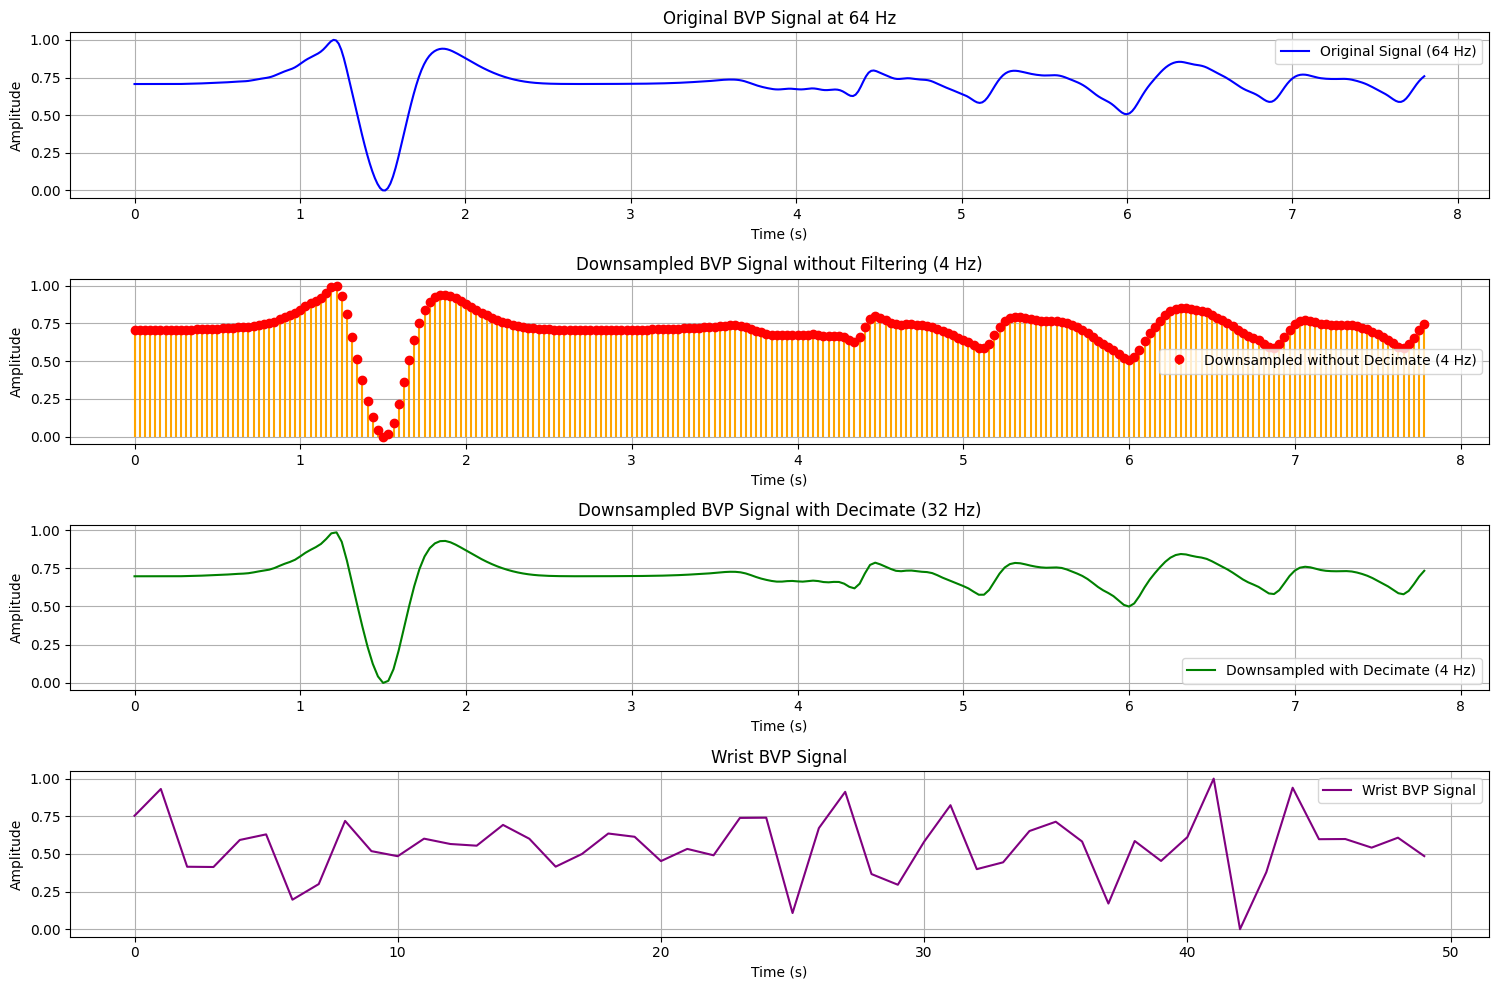

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import decimate

# Load BVP data from the merged_data.csv file
csv_file_path = os.path.join(DATA_PATH, 'S2', 'BVP.csv')
merged_df = pd.read_csv(csv_file_path)

# Convert merged_df to a numpy array
merged_df = merged_df.to_numpy()
# Extract BVP data for a specific subject (e.g., subject_id = 2)
bvp_data = merged_df[2:502]

bvp_data_normalized = (bvp_data - np.min(bvp_data)) / (np.max(bvp_data) - np.min(bvp_data))

# Create a time vector for the original signal
fs_original = 64  # original sampling frequency
t = np.linspace(0, len(bvp_data_normalized) / fs_original, len(bvp_data_normalized), endpoint=False)

# Downsample without filtering (simple slicing)
downsampling_factor = 2
t_no_filter = t[::downsampling_factor]
bvp_no_filter = bvp_data_normalized[::downsampling_factor]

downsampling_factor = 2
bvp_decimated = decimate(bvp_data_normalized.flatten(), downsampling_factor)

# New time vector for the decimated signal
t_decimated = np.linspace(0, len(bvp_decimated) / (fs_original / downsampling_factor), len(bvp_decimated), endpoint=False)

# Load BVP data from the wrist CSV file
wrist_csv_file_path = os.path.join(DATA_PATH, 'S2', 'wrist', 'S2.csv')
wrist_df = pd.read_csv(wrist_csv_file_path)
wrist_bvp_data = wrist_df['BVP'].values
# Extract BVP data for a specific subject (e.g., subject_id = 2)
wrist_bvp_data = wrist_bvp_data[800:850]

# Normalize wrist BVP data
wrist_bvp_data_normalized = (wrist_bvp_data - np.min(wrist_bvp_data)) / (np.max(wrist_bvp_data) - np.min(wrist_bvp_data))

# Plotting
plt.figure(figsize=(15, 10))

# Original Signal
plt.subplot(4, 1, 1)
plt.plot(t, bvp_data_normalized, label='Original Signal (64 Hz)', color='blue')
plt.title('Original BVP Signal at 64 Hz')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

# Downsampled without Decimate (simple slicing)
plt.subplot(4, 1, 2)
plt.stem(t_no_filter, bvp_no_filter, label='Downsampled without Decimate (4 Hz)', linefmt='orange', markerfmt='ro', basefmt=" ")
plt.title('Downsampled BVP Signal without Filtering (4 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

# Downsampled with Decimate
plt.subplot(4, 1, 3)
plt.plot(t_decimated, bvp_decimated, label='Downsampled with Decimate (4 Hz)', color='green')
plt.title('Downsampled BVP Signal with Decimate (32 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

# Wrist BVP Signal
plt.subplot(4, 1, 4)
plt.plot(wrist_bvp_data_normalized, label='Wrist BVP Signal', color='purple')
plt.title('Wrist BVP Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
